<a href="https://colab.research.google.com/github/lapshinaaa/applied-statistics-tasks/blob/main/AS4_Nonparametric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="500">

# Nonparametric Statistics
</center>

## Task 1 (Crashing Mann–Whitney U test)

Тест Манна-Уитни [довольно легко сломать.](https://habr.com/ru/companies/avito/articles/709596/)

Главная предпосылка теста заключается в том, что распределение не меняется, но у него происходит сдвиг.

\begin{equation*}
    \begin{aligned}
    & H_0: F_X(x) = F_Y(y) \\
    & H_A: F_X(x) = F_Y(y + m), m \ne 0
    \end{aligned}
\end{equation*}


<center>
<img src='https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/sem12_more_ab/mw.png' align='center' width="300x">
</center>

Воспользуемся этим.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from collections import defaultdict
from sklearn.metrics import roc_curve, auc

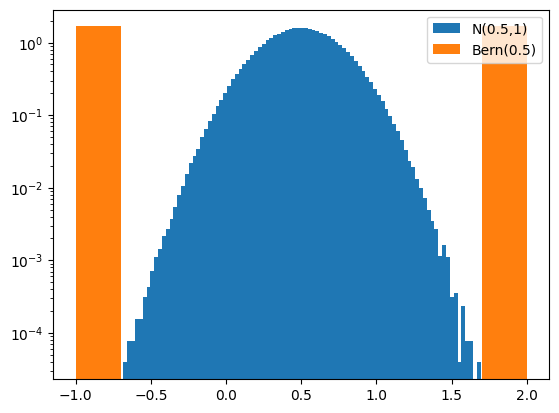

In [1]:
n_obs = 10**6
x = sts.norm(0.5, 0.25).rvs(n_obs)
y = 3*sts.bernoulli(0.5).rvs(n_obs) - 1

# polarized opinions as a result of AB test

plt.hist(x, bins=100, density=True, label='N(0.5,1)');
plt.hist(y, density=True, label='Bern(0.5)', log=True);
plt.legend();

In [2]:
# Mann-Whitney says there's no change where there obviously is
_, pval = sts.mannwhitneyu(x, y, alternative='two-sided')
pval

np.float64(0.8015380886349799)

In [4]:
# Kolmogorod-Smirnov test is noticing the shift
sts.ks_2samp(x, y)

KstestResult(statistic=np.float64(0.500101), pvalue=np.float64(0.0), statistic_location=np.float64(-1.0), statistic_sign=np.int8(-1))

__а) [5 баллов]__ Проведите для подобной ситуации с поляризацией больше испытаний. Постройте для теста Манна-Уитни и для KS-теста ROC-кривые.

In [7]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Distribution p-value/ROC-curve', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

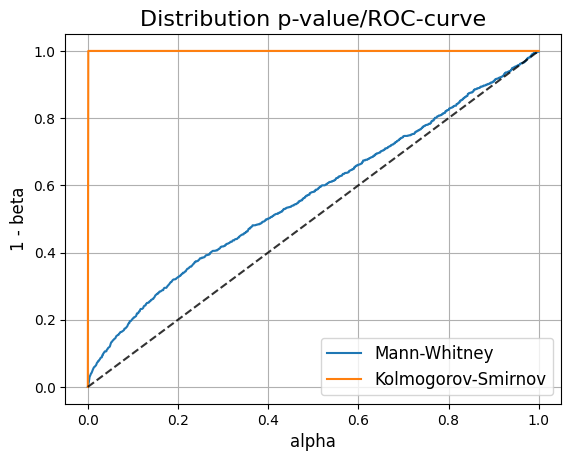

In [9]:
n_sim = 1000
sample_size = 500

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x = sts.norm(0.5, 0.25).rvs(n_obs)
    y = 3*sts.bernoulli(0.5).rvs(n_obs) - 1

    _, pval_mw = sts.mannwhitneyu(x, y, alternative='two-sided')
    _, pval_ks = sts.ks_2samp(x, y)

    dict_pvalues['Mann-Whitney'].append(pval_mw)
    dict_pvalues['Kolmogorov-Smirnov'].append(pval_ks)

plot_pvalue_distribution(dict_pvalues)

As can be seen in the plot above, the Kolmogorov-Smirnov test clearly saw the distinction in the distribution immediately, unlike the Mann-Whitney one.

__б) [5 баллов]__ Придумайте ещё какой-нибудь пример, где тест Манна-Уитни сломается, а KS-тест нет. Нарисуйте для него ROC-кривые.

A very interesting case I found while reading this article: https://habr.com/ru/companies/avito/articles/709596/

Another example where the Mann–Whitney test can fail while the Kolmogorov–Smirnov test succeeds comes from a marketplace scenario. Suppose we are trying to increase the number of transactions on an online classifieds platform (e.g., Avito). A transaction is defined as the event where a seller finds a buyer for their listing.

To achieve this, we introduce new mandatory parameters in the listing form. As a result, posting an item becomes more complicated. Some sellers dislike the change and drop out, but for the remaining sellers, it becomes easier for buyers to find relevant listings using the new filters.

Before the change:

* There were 100 sellers.

* On average, each completed 2 transactions → total = 200 transactions.

After the change:

* Only 70 sellers remain active (30 left due to the new requirements).

* The remaining sellers now average 3 transactions each, since buyers can find items more easily.

* Total = 70 × 3 = 210 transactions (slightly more than before).

So, at the population level, the initiative increased total transactions. But the distribution of transactions per seller has changed: a mass of sellers dropped out (producing a spike at 0), while the rest became more productive (heavier right tail).

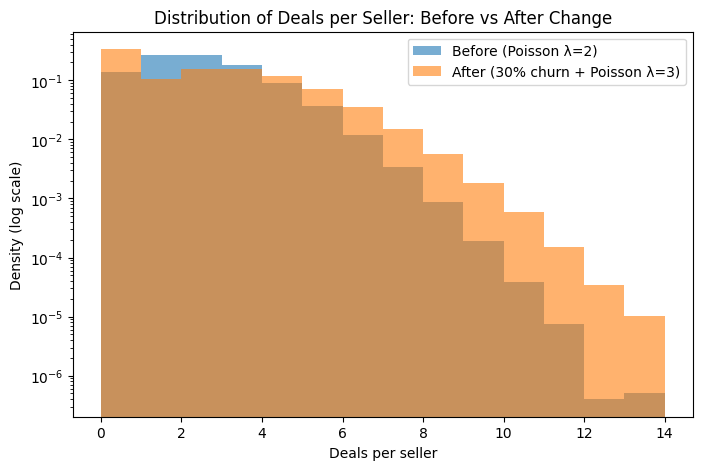

In [12]:
n_obs = 10**7 # number of sellers

before = sts.poisson(2).rvs(n_obs)
p_churn = 0.30
churned = sts.bernoulli(p_churn).rvs(n_obs)  # 1=churn, 0=active
after = np.zeros(n_obs, dtype=int)
after[churned == 0] = sts.poisson(3).rvs((churned == 0).sum())


plt.figure(figsize=(8,5))
plt.hist(before, bins=range(0,15), density=True, alpha=0.6, label="Before (Poisson λ=2)")
plt.hist(after, bins=range(0,15), density=True, alpha=0.6, label="After (30% churn + Poisson λ=3)")
plt.yscale("log")  # log-scale to emphasize spike at 0 + tail differences
plt.xlabel("Deals per seller")
plt.ylabel("Density (log scale)")
plt.title("Distribution of Deals per Seller: Before vs After Change")
plt.legend()
plt.show()

First, we'll need functions to simulate these two distributions: before and after the changes in the filtering system.

In [13]:
def sample_before(n, lam=2.0):
    # before: Poisson(2)
    return sts.poisson(lam).rvs(n)

def sample_after(n, p_churn=0.30, lam_active=3.0):
    # after: zero-inflated Poisson:
    # with prob p_churn -> 0 deals (churned),
    # else Poisson(lam_active)
    churn = sts.bernoulli(p_churn).rvs(n)
    active_n = n - churn.sum()
    deals_active = sts.poisson(lam_active).rvs(active_n)
    out = np.zeros(n, dtype=int)
    out[churn == 0] = deals_active
    return out

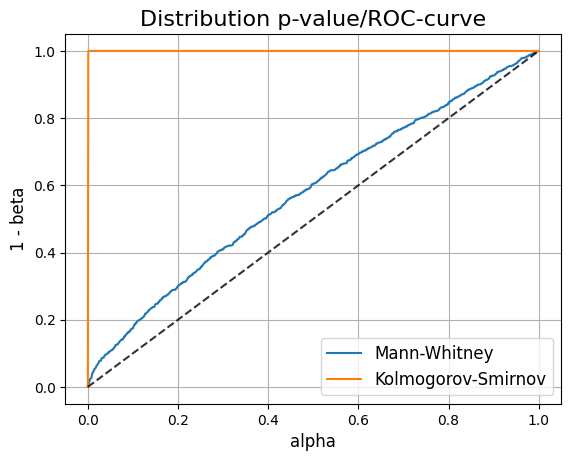

In [17]:
n_sim = 1000
n_per_group = 500

dict_p = defaultdict(list)

for _ in range(n_sim):
    x = sample_before(n_per_group, lam=2.0)                 # BEFORE
    y = sample_after(n_per_group, p_churn=0.30, lam_active=3.0)  # AFTER (ZI + heavier tail)

    # Mann–Whitney (two-sided). Lots of ties -> use 'asymptotic' method.
    _, p_mw = sts.mannwhitneyu(x, y, alternative='two-sided', method='asymptotic')

    # KS two-sample
    _, p_ks = sts.ks_2samp(x, y, alternative='two-sided', method='asymp')

    dict_p['Mann-Whitney'].append(p_mw)
    dict_p['Kolmogorov-Smirnov'].append(p_ks)

plot_pvalue_distribution(dict_p)

__в) [бонусные 5 баллов]__ Реализуйте [перестановочный тест](https://youtu.be/uKqsqAJtdzI) и с помощью симуляций продемонстрируйте, чето он обладает ровно такими же проблемами, как и тест Манна-Уитни.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you